# INST447 - Data Sources and Manipulation Midterm Exam

# Question 1. 

Understanding What We're Working With

Basic Structure:
Dataset Shape: (1097, 14)
Number of Educational Texts (row observations): 1097
Number of variables (columns): 14

Column names and types:
UID                                  int64
Clear ID                             int64
Grade                                int64
Flesch Kincaid                     float64
Text                                object
Sentence Score                      object
Sentence Score Rationale            object
Vocabulary Score                    object
Vocabulary Score Rationale          object
Tier 2 Words                        object
Tier 3 Words                        object
Archaic Words                       object
Other Complex Words                 object
Background Knowledge Assumption     object
dtype: object

First few rows:
   UID  Clear ID  Grade  Flesch Kincaid  \
0    0      1901      3            7.97   
1    1      1901      4            7.97   
2    2      1914      3            6.65   
3    3      1914      4            6.65 

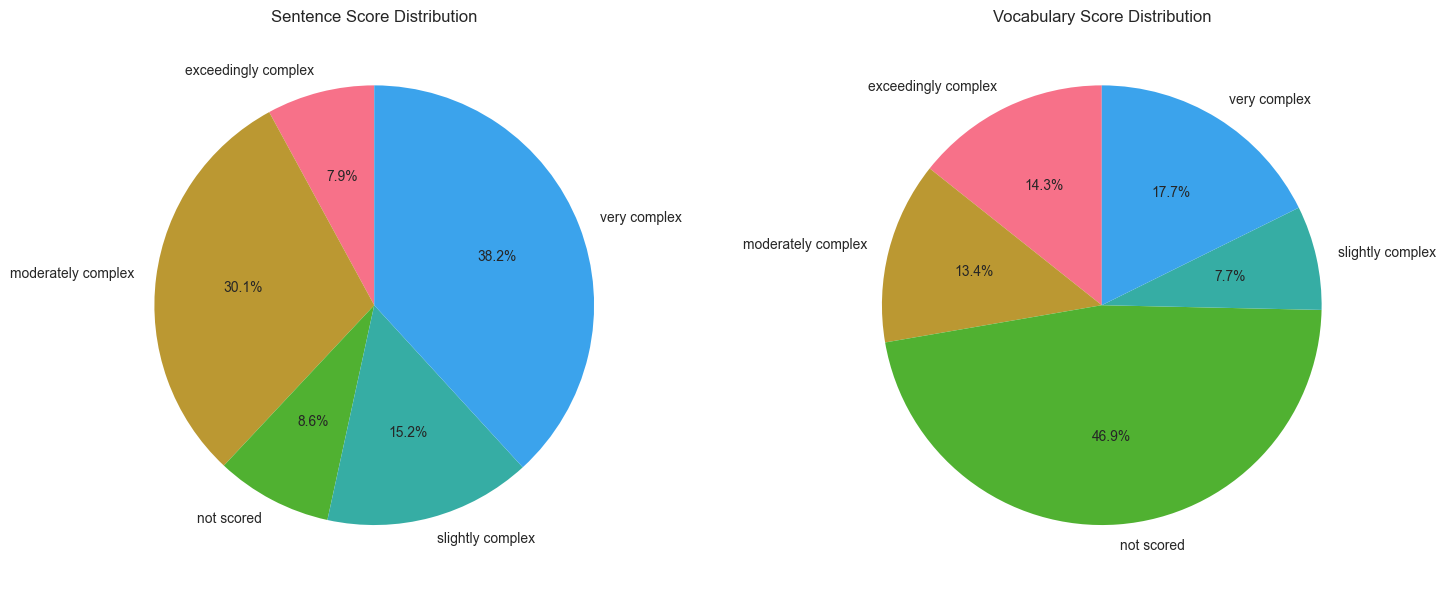

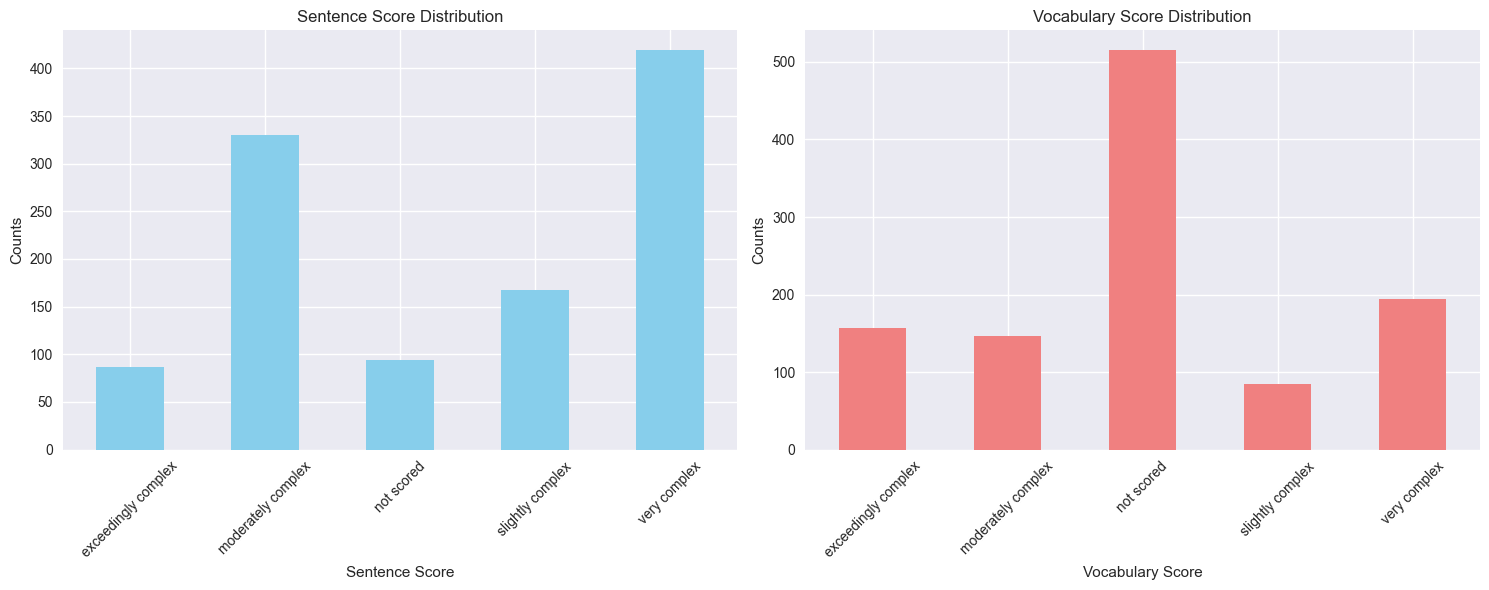

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from typing import Dict, List, Set, Tuple
import numpy as np
from collections import defaultdict


df = pd.read_csv('text_complexity.csv')

# basic structure 

print("Basic Structure:")
print(f"Dataset Shape: {df.shape}")
print(f"Number of Educational Texts (row observations): {df.shape[0]}")
print(f"Number of variables (columns): {df.shape[1]}")
print("\nColumn names and types:")
print(df.dtypes)
print("\nFirst few rows:")
print(df.head())

# duplicate Clear IDs check (unique texts)

unique_ids = df['Clear ID'].nunique()
print(f"\nUnique Clear IDs: {unique_ids}")
print(f"Duplicate texts: {df.shape[0] - unique_ids}")

# missing data 

missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

missing_summary = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percent
}).sort_values('Missing Percentage', ascending=False)

print("Missing data:")
print(missing_summary[missing_summary['Missing Count'] > 0])

# columns with >20% missing data

high_missing = missing_summary[missing_summary['Missing Percentage'] > 20]
print(f"\nColumns with >20% missing data: {len(high_missing)}")
print(high_missing.index.tolist())

# complexity landscape

print("\nComplexity Landscape")

# sentence scores

sentence_dist = df['Sentence Score'].value_counts().sort_index()
print("Sentence Score Distribution:")
print(sentence_dist)

# vocabulary scores  

vocab_dist = df['Vocabulary Score'].value_counts().sort_index()
print("\nVocabulary Score Distribution:")
print(vocab_dist)

# visuals

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# sentence score pie chart

sentence_dist.plot.pie(ax=ax1, autopct='%1.1f%%', startangle=90)
ax1.set_title('Sentence Score Distribution')
ax1.set_ylabel('')

# vocab score pie chart

vocab_dist.plot.pie(ax=ax2, autopct='%1.1f%%', startangle=90)
ax2.set_title('Vocabulary Score Distribution')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

# bar charts

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sentence_dist.plot.bar(ax=ax1, color='skyblue')
ax1.set_title('Sentence Score Distribution')
ax1.set_xlabel('Sentence Score')
ax1.set_ylabel('Counts')
ax1.tick_params(axis='x', rotation=45)

vocab_dist.plot.bar(ax=ax2, color='lightcoral')
ax2.set_title('Vocabulary Score Distribution')
ax2.set_xlabel('Vocabulary Score')
ax2.set_ylabel('Counts')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Question 2. 

Decoding the Annotation Process

Annotator Counts:
Sentence annotators:
sentence_annotators_count
0     94
2     80
3    915
4      7
6      1
Name: count, dtype: int64

Vocabulary annotators:
vocab_annotators_count
0    514
1      2
2     92
3    476
4     13
Name: count, dtype: int64


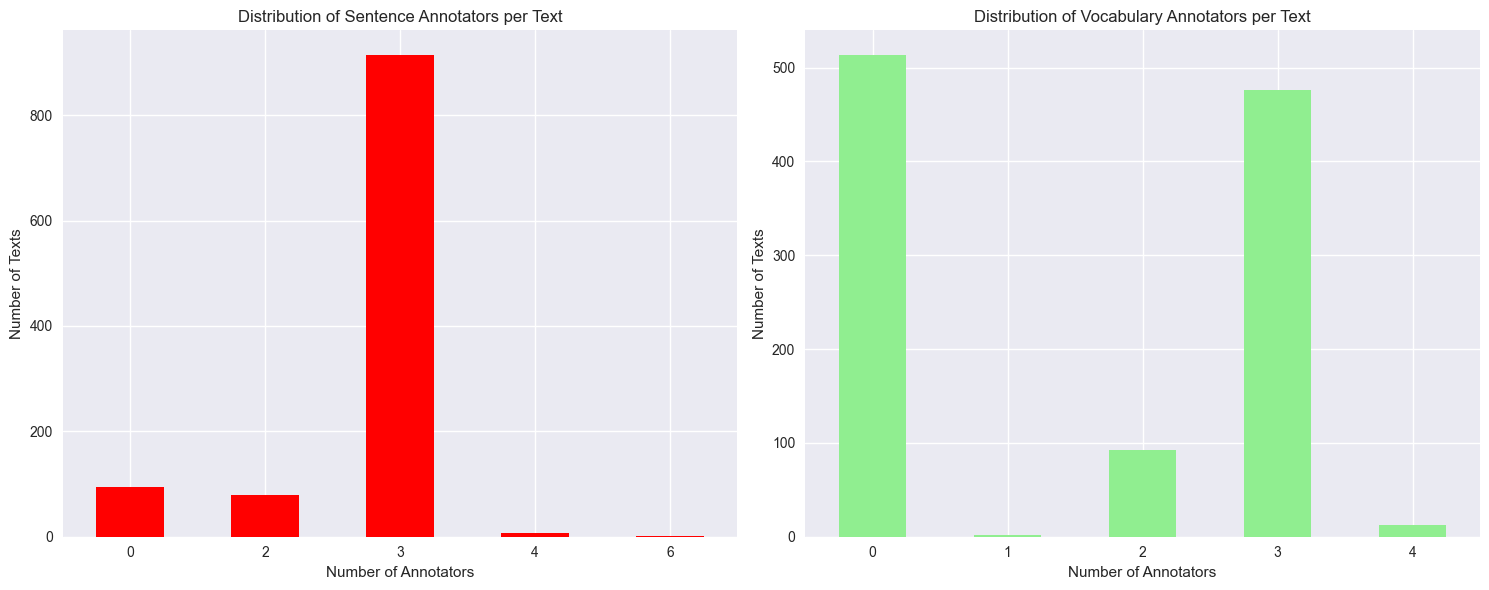


Observations:
Most texts have 3 sentence annotators
Most texts have 0 vocabulary annotators
The pattern is generally similar between sentence and vocabulary annotations.


In [7]:
# count annotators from rationale text

def count_annotators(rationale_text, prefix):
    if pd.isna(rationale_text):
        return 0
    
    # find all annotator mentions like ss_annotator_1, ss_annotator_2, etc.
    
    pattern = rf'{prefix}_annotator_(\d+):'
    matches = re.findall(pattern, rationale_text)
    return len(set(matches))  # return count of unique annotators

# apply to sentence score rationale

df['sentence_annotators_count'] = df['Sentence Score Rationale'].apply(
    lambda x: count_annotators(x, 'ss') if pd.notna(x) else 0
)

# apply to vocabulary score rationale  

df['vocab_annotators_count'] = df['Vocabulary Score Rationale'].apply(
    lambda x: count_annotators(x, 'vocab') if pd.notna(x) else 0
)

print("Annotator Counts:")
print("Sentence annotators:")
print(df['sentence_annotators_count'].value_counts().sort_index())

print("\nVocabulary annotators:")
print(df['vocab_annotators_count'].value_counts().sort_index())

# setting up bar charts

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# sentence annotators

sentence_annotation_counts = df['sentence_annotators_count'].value_counts().sort_index()
sentence_annotation_counts.plot.bar(ax=ax1, color='red')
ax1.set_title('Distribution of Sentence Annotators per Text')
ax1.set_xlabel('Number of Annotators')
ax1.set_ylabel('Number of Texts')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

# vocab annotators

vocab_annotation_counts = df['vocab_annotators_count'].value_counts().sort_index()
vocab_annotation_counts.plot.bar(ax=ax2, color='lightgreen')
ax2.set_title('Distribution of Vocabulary Annotators per Text')
ax2.set_xlabel('Number of Annotators')
ax2.set_ylabel('Number of Texts')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

# observation

print("\nObservations:")
print(f"Most texts have {sentence_annotation_counts.idxmax()} sentence annotators")
print(f"Most texts have {vocab_annotation_counts.idxmax()} vocabulary annotators")
print("The pattern is generally similar between sentence and vocabulary annotations.")

# Question 3. 

Is Tier Classification Consistent? 

In [41]:
# consensus within grade level (Grade 3)

print("Part A: Consistency Within Grade 3")

# grade 3 texts

grade3_df = df[df['Grade'] == 3].copy()

# parse comma-separated word lists

def parse_word_list(word_string):
    if pd.isna(word_string) or word_string == 'not scored':
        return []
    
    # split by comma and strip whitespace
    
    return [word.strip().lower() for word in word_string.split(',')]

# parse Tier 2 and Tier 3 words for Grade 3

grade3_df['tier2_words_parsed'] = grade3_df['Tier 2 Words'].apply(parse_word_list)
grade3_df['tier3_words_parsed'] = grade3_df['Tier 3 Words'].apply(parse_word_list)

# sets of all Tier 2 and Tier 3 words in Grade 3

all_tier2_grade3 = set()
all_tier3_grade3 = set()

for words in grade3_df['tier2_words_parsed']:
    all_tier2_grade3.update(words)
    
for words in grade3_df['tier3_words_parsed']:
    all_tier3_grade3.update(words)

# words that appear in both tiers

inconsistent_words_grade3 = all_tier2_grade3.intersection(all_tier3_grade3)

print(f"Number of words appearing in both Tier 2 and Tier 3 within Grade 3: {len(inconsistent_words_grade3)}")
print("Examples of inconsistent words:")

if inconsistent_words_grade3:
    print(list(inconsistent_words_grade3)[:10])  # first 10 examples

# grade classification

print("\nPart B: Grade-Dependent Classification")

# grade 4 texts

grade4_df = df[df['Grade'] == 4].copy()

# words for Grade 4

grade4_df['tier2_words_parsed'] = grade4_df['Tier 2 Words'].apply(parse_word_list)
grade4_df['tier3_words_parsed'] = grade4_df['Tier 3 Words'].apply(parse_word_list)

# sets for Grade 4

all_tier2_grade4 = set()
all_tier3_grade4 = set()

for words in grade4_df['tier2_words_parsed']:
    all_tier2_grade4.update(words)
    
for words in grade4_df['tier3_words_parsed']:
    all_tier3_grade4.update(words)

# words that switch tiers between grades

tier3_in_grade3_but_tier2_in_grade4 = all_tier3_grade3.intersection(all_tier2_grade4)
tier2_in_grade3_but_tier3_in_grade4 = all_tier2_grade3.intersection(all_tier3_grade4)

print(f"Words that are Tier 3 in Grade 3 but Tier 2 in Grade 4: {len(tier3_in_grade3_but_tier2_in_grade4)}")
if tier3_in_grade3_but_tier2_in_grade4:
    print("Examples:", list(tier3_in_grade3_but_tier2_in_grade4)[:10])

print(f"Words that are Tier 2 in Grade 3 but Tier 3 in Grade 4: {len(tier2_in_grade3_but_tier3_in_grade4)}")
if tier2_in_grade3_but_tier3_in_grade4:
    print("Examples:", list(tier2_in_grade3_but_tier3_in_grade4)[:10])

print("\nInterpretation:")
print("The presence of words appearing in both tiers suggests that vocabulary classification")
print("has subjective elements. Annotators may interpret word tiers differently based on")
print("their understanding of what constitutes 'domain-specific' vs 'general academic' vocabulary.")
print("The grade-dependent switching further indicates that tier classification is context-dependent")
print("rather than being an objective property of the words themselves.")

Part A: Consistency Within Grade 3
Number of words appearing in both Tier 2 and Tier 3 within Grade 3: 767
Examples of inconsistent words:
['relations', 'asteroids', 'gas', 'husked', 'trauma', 'plows', 'vengeance', 'scribes', 'muscle', 'nervous system']

Part B: Grade-Dependent Classification
Words that are Tier 3 in Grade 3 but Tier 2 in Grade 4: 343
Examples: ['relations', 'asteroids', 'poet', 'gas', 'warlike', 'stable', 'replication', 'pillars', 'tombs', 'rhythm']
Words that are Tier 2 in Grade 3 but Tier 3 in Grade 4: 306
Examples: ['distant', 'glaciers', 'cells', 'asteroids', 'hardware', 'software', 'agriculture', 'tissue', 'percent', 'protein']

Interpretation:
The presence of words appearing in both tiers suggests that vocabulary classification
has subjective elements. Annotators may interpret word tiers differently based on
their understanding of what constitutes 'domain-specific' vs 'general academic' vocabulary.
The grade-dependent switching further indicates that tier classi

# Question 4.  

What Predicts Vocabulary Complexity? 



Tier 3 Word Vocabulary Complexity Prediction:
Mean Tier 3 word counts by Vocabulary Score:
                      mean   std  count
Vocabulary Score                       
exceedingly complex  14.36  7.76    157
moderately complex    7.21  4.12    147
slightly complex      4.04  2.75     84
very complex          9.45  5.27    194


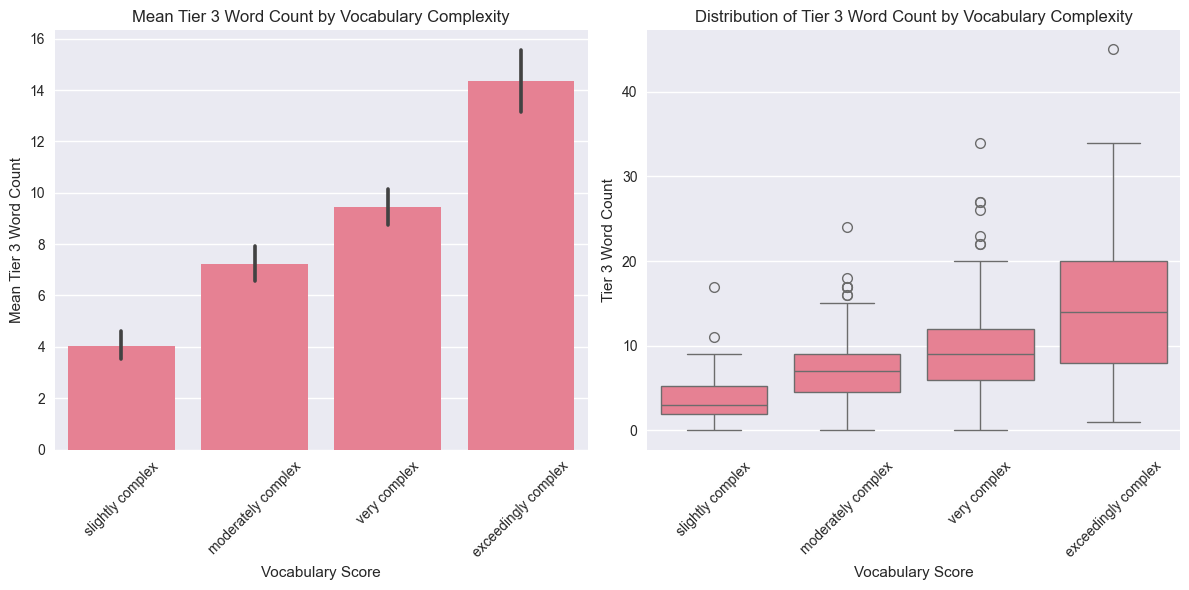


Interpretation:
The relationship shows a generally positive trend: texts rated as more complex
tend to have more Tier 3 words on average. However, there is considerable overlap
in the distributions, suggesting that while Tier 3 word count is a factor in
complexity assessment, it's not the only determinant. Annotators likely consider
other aspects of vocabulary beyond just domain-specific terminology.


In [ ]:
print("Tier 3 Word Vocabulary Complexity Prediction:")


analysis_df = df.copy()

# counting Tier 3 words for each text

analysis_df['tier3_count'] = analysis_df['Tier 3 Words'].apply(
    lambda x: len(parse_word_list(x))
)

# no texts with 'not scored' vocabulary scores

vocab_scored_df = analysis_df[analysis_df['Vocabulary Score'] != 'not scored'].copy()

# grouping by vocab score and calculating mean Tier 3 count

grouped_means = vocab_scored_df.groupby('Vocabulary Score')['tier3_count'].agg(['mean', 'std', 'count']).round(2)
print("Mean Tier 3 word counts by Vocabulary Score:")
print(grouped_means)



plt.figure(figsize=(12, 6))

# bar chart

plt.subplot(1, 2, 1)
sns.barplot(data=vocab_scored_df, x='Vocabulary Score', y='tier3_count', order=['slightly complex', 'moderately complex', 'very complex', 'exceedingly complex'])
plt.title('Mean Tier 3 Word Count by Vocabulary Complexity')
plt.xlabel('Vocabulary Score')
plt.ylabel('Mean Tier 3 Word Count')
plt.xticks(rotation=45)

# box plot

plt.subplot(1, 2, 2)
sns.boxplot(data=vocab_scored_df, x='Vocabulary Score', y='tier3_count', order=['slightly complex', 'moderately complex', 'very complex', 'exceedingly complex'])
plt.title('Distribution of Tier 3 Word Count by Vocabulary Complexity')
plt.xlabel('Vocabulary Score')
plt.ylabel('Tier 3 Word Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("The relationship shows a generally positive trend: texts rated as more complex")
print("tend to have more Tier 3 words on average. However, there is considerable overlap")
print("in the distributions, suggesting that while Tier 3 word count is a factor in")
print("complexity assessment, it's not the only determinant. Annotators likely consider")
print("other aspects of vocabulary beyond just domain-specific terminology.")

# Question 5. 

Can LLM Annotate Vocabulary Tiers?

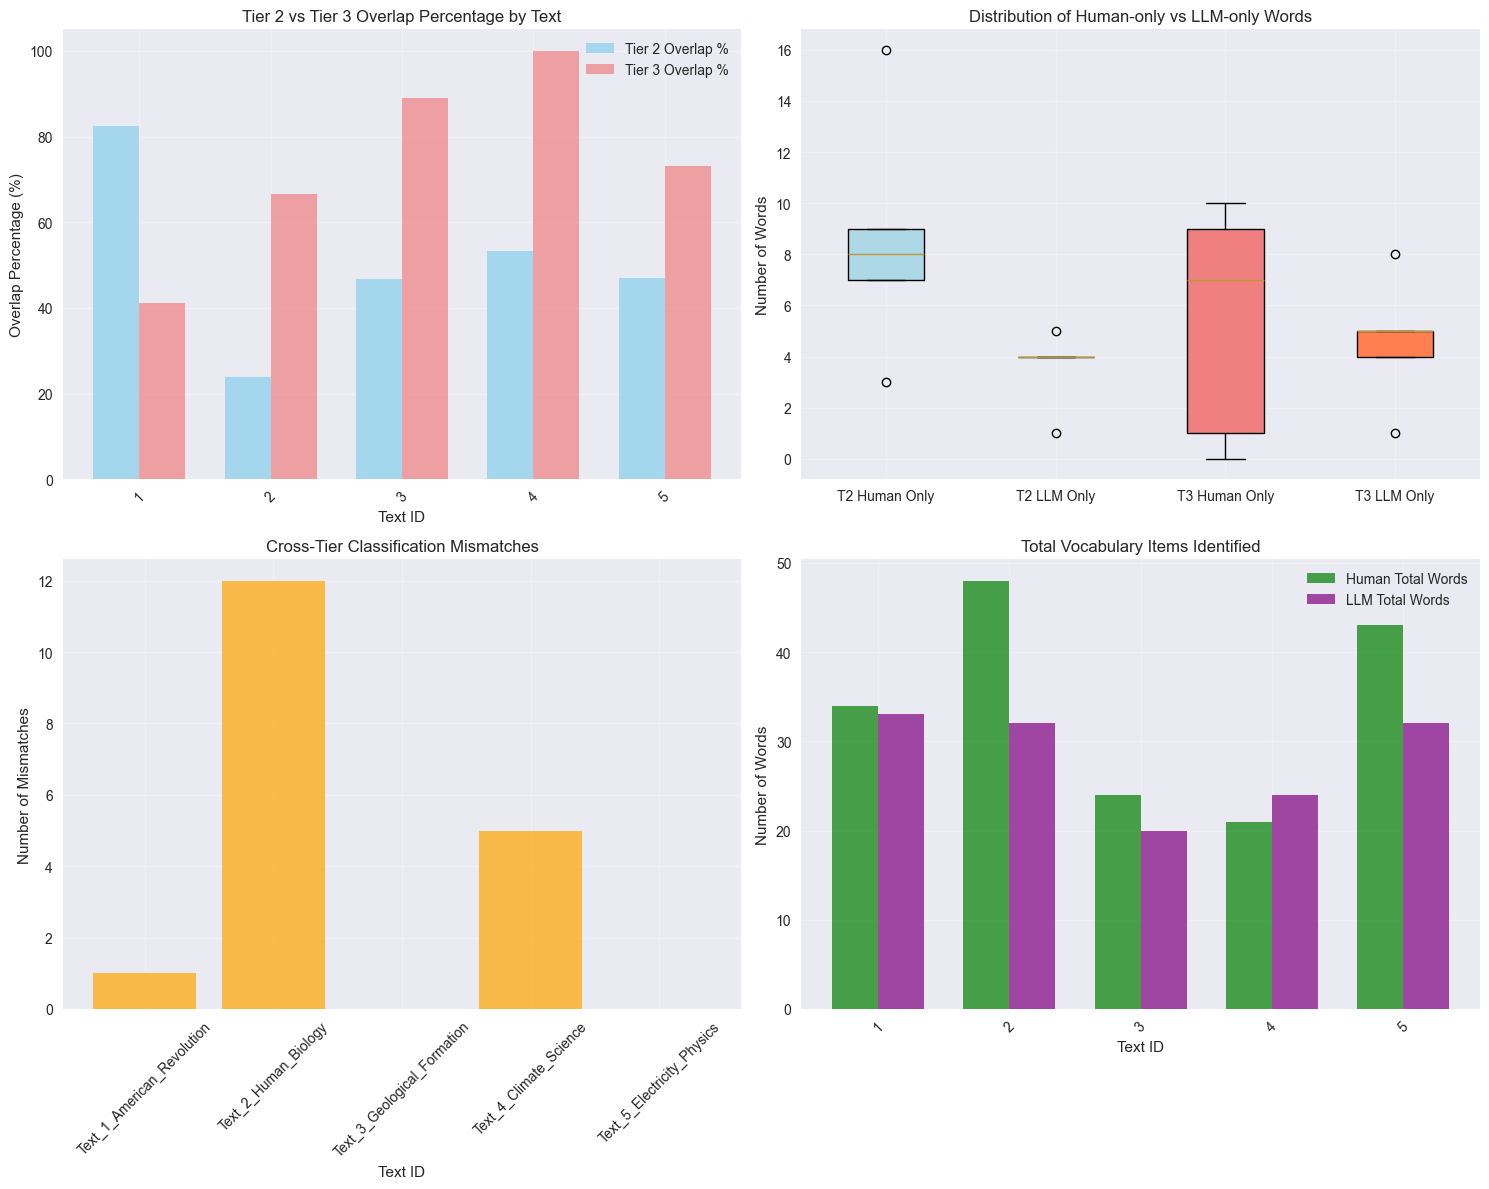

Overlap Analysis:

Text Tier2_Overlap Tier3_Overlap Total_Overlap  Cross_Mismatches LLM_Expansion_Rate
   1 14/17 (82.4%)  7/17 (41.2%) 21/34 (61.8%)                 1              36.4%
   2  5/21 (23.8%) 18/27 (66.7%) 23/48 (47.9%)                12              28.1%
   3  7/15 (46.7%)   8/9 (88.9%) 15/24 (62.5%)                 0              25.0%
   4  8/15 (53.3%)  6/6 (100.0%) 14/21 (66.7%)                 5              41.7%
   5  8/17 (47.1%) 19/26 (73.1%) 27/43 (62.8%)                 0              15.6%

Cross-Text Consistency Analysis

Words classified differently by humans across texts: 20
Examples: ['platelets', 'electrolytes', 'volume', 'moisture', 'current', 'plasma', 'serum', 'infections', 'vertebrates', 'organism']


Performance:

Overall Tier 2 Overlap: 42/85 (49.4%)
Overall Tier 3 Overlap: 58/85 (68.2%)
Overall Cross-tier Mismatches: 18

Domain-Specific Performance Analysis

American: Average Overlap = 61.8%
Human: Average Overlap = 47.9%
Geological: Average Over

In [ ]:
class VocabularyOverlapAnalyzer:
    def __init__(self):
        self.results = {}
        
    def parse_annotations(self, human_tier2: List[str], human_tier3: List[str], 
                         llm_tier2: List[str], llm_tier3: List[str], text_id: str) -> Dict:
        """Parse and compare human vs LLM annotations for a single text"""
        
        # sets for comparison
        
        human_t2_set = set(word.lower().strip() for word in human_tier2)
        human_t3_set = set(word.lower().strip() for word in human_tier3)
        llm_t2_set = set(word.lower().strip() for word in llm_tier2)
        llm_t3_set = set(word.lower().strip() for word in llm_tier3)
        
        # overlaps and differences
        
        analysis = {
            'text_id': text_id,
            'human_tier2_count': len(human_t2_set),
            'human_tier3_count': len(human_t3_set),
            'llm_tier2_count': len(llm_t2_set),
            'llm_tier3_count': len(llm_t3_set),
            
            # tier 2 analysis
            
            'tier2_overlap': len(human_t2_set & llm_t2_set),
            'tier2_human_only': len(human_t2_set - llm_t2_set),
            'tier2_llm_only': len(llm_t2_set - human_t2_set),
            
            # tier 3 analysis
            
            'tier3_overlap': len(human_t3_set & llm_t3_set),
            'tier3_human_only': len(human_t3_set - llm_t3_set),
            'tier3_llm_only': len(llm_t3_set - human_t3_set),
            
            # cross-tier mismatches
    
            'human_t2_llm_t3': len(human_t2_set & llm_t3_set),
            'human_t3_llm_t2': len(human_t3_set & llm_t2_set),
            
            # word lists
            
            'tier2_overlap_words': list(human_t2_set & llm_t2_set),
            'tier3_overlap_words': list(human_t3_set & llm_t3_set),
            'tier2_human_only_words': list(human_t2_set - llm_t2_set),
            'tier2_llm_only_words': list(llm_t2_set - human_t2_set),
            'tier3_human_only_words': list(human_t3_set - llm_t3_set),
            'tier3_llm_only_words': list(llm_t3_set - human_t3_set),
            'cross_mismatch_words': {
                'human_t2_llm_t3': list(human_t2_set & llm_t3_set),
                'human_t3_llm_t2': list(human_t3_set & llm_t2_set)
            }
        }
        
        # percentages
        
        analysis['tier2_overlap_pct'] = (analysis['tier2_overlap'] / analysis['human_tier2_count'] * 100) if analysis['human_tier2_count'] > 0 else 0
        analysis['tier3_overlap_pct'] = (analysis['tier3_overlap'] / analysis['human_tier3_count'] * 100) if analysis['human_tier3_count'] > 0 else 0
        analysis['total_overlap_pct'] = ((analysis['tier2_overlap'] + analysis['tier3_overlap']) / 
                                       (analysis['human_tier2_count'] + analysis['human_tier3_count']) * 100) if (analysis['human_tier2_count'] + analysis['human_tier3_count']) > 0 else 0
        
        return analysis

# analyzer

analyzer = VocabularyOverlapAnalyzer()

# annotation data from the provided examples

annotation_data = [
    {
        'text_id': 'Text_1_American_Revolution',
        'human_tier2': ["approve", "approved", "attack", "columns", "considered", "convince", "destroy", 
                       "divide", "engagements", "force", "recognize", "relief", "relieve", "submitted", 
                       "surrendered", "turning point", "victory"],
        'human_tier3': ["aid", "american revolution", "army", "battle", "battle of bemis heights", 
                       "battle of freeman's farm", "battle of saratoga", "british", "colonies", 
                       "continental army", "engagements", "fort", "military plans", "parties", 
                       "rebel american government", "soldiers", "surrender"],
        'llm_tier2': ["considered", "turning point", "engagements", "victory", "helped", "convince", 
                     "recognize", "approve", "plan", "attack", "destroy", "submitted", "divide", 
                     "approved", "moving", "split", "force", "relieve"],
        'llm_tier3': ["battle of saratoga", "american revolution", "battle of freeman's farm", 
                     "battle of bemis heights", "general", "continental army", "british", "philadelphia", 
                     "rebel", "colonies", "hudson river valley", "lake ontario", "mohawk valley", 
                     "fort stanwix", "colonel"]
    },
    {
        'text_id': 'Text_2_Human_Biology',
        'human_tier2': ["antibodies", "blood cells", "carbon dioxide", "clot", "electrolytes", "gases", 
                       "heal", "infections", "liters", "nutrients", "organism", "plasma", "platelets", 
                       "proteins", "serum", "tissues", "various", "volume", "vertebrates", "waste", "wounds"],
        'human_tier3': ["albumin", "antibodies", "blood plasma", "cells", "clot", "clotting", 
                       "clotting factors", "electrolytes", "fibrinogen", "fibrinogen serum", "hemoglobin", 
                       "immunoglobulins", "infections", "lipids", "non-protein hormones", "nutrients", 
                       "organism", "plasma", "platelets", "protein hormones", "proteins", "red blood cells", 
                       "serum", "tissue", "vertebrates", "volume", "white blood cells"],
        'llm_tier2': ["liquid", "organism", "tissues", "takes away", "made up of", "various", "heal", 
                     "float", "volume"],
        'llm_tier3': ["blood", "heart", "nutrients", "oxygen", "waste", "carbon dioxide", "vertebrates", 
                     "blood plasma", "red blood cells", "white blood cells", "platelets", "clot", 
                     "hemoglobin", "infections", "electrolytes", "lipids", "albumin", "antibodies", 
                     "immunoglobulins", "clotting factors", "protein hormones", "fibrinogen", "serum"]
    },
    {
        'text_id': 'Text_3_Geological_Formation',
        'human_tier2': ["age", "amazed", "carve", "caused", "effect", "enough", "exact", "features", 
                       "form", "formed", "harmless", "hike", "league", "through", "wash"],
        'human_tier3': ["canyon", "colorado", "colorado river", "earth", "grand canyon", "mississippi river", 
                       "rainstorm", "rock", "soil"],
        'llm_tier2': ["features", "formed", "harmless", "effect", "carve", "create", "believe", "learned", 
                     "unsure", "exact", "amazed"],
        'llm_tier3': ["earth", "grand canyon", "colorado river", "mississippi river", "canyon", "soil", 
                     "rock", "scientists", "rainstorm"]
    },
    {
        'text_id': 'Text_4_Climate_Science',
        'human_tier2': ["climate", "depend", "determine", "distance", "equator", "factors", "features", 
                       "impact", "latitude", "local", "major", "moisture", "precipitation", "types", "vary"],
        'human_tier3': ["climate", "equator", "latitude", "moisture", "precipitation", "temperature"],
        'llm_tier2': ["distance", "vary", "factors", "impact", "local", "wonder", "features", "role", 
                     "cause", "major", "based on", "determine", "depend on"],
        'llm_tier3': ["equator", "climate", "mountains", "oceans", "latitude", "mountain ranges", 
                     "moisture", "temperature", "precipitation", "plants", "animals"]
    },
    {
        'text_id': 'Text_5_Electricity_Physics',
        'human_tier2': ["bound", "carried", "charge", "create", "creates", "current", "device", "fields", 
                       "flow", "freely", "loosely", "measured", "measuring", "moving", "particles", 
                       "rate", "surface"],
        'human_tier3': ["ammeter", "ampere", "anmeter", "atom", "charge carriers", "circuits", "conduction", 
                       "conduction electrons", "conductors", "coulomb", "current", "electric charge", 
                       "electrolyte", "electrons", "generators", "incandescent", "inductors", "ions", 
                       "joule heating", "magnetic fields", "metals", "motors", "particles", "plasma", 
                       "si unit", "wire"],
        'llm_tier2': ["flow", "carried", "measuring", "rate", "device", "create", "loosely", "bound", 
                     "move freely"],
        'llm_tier3': ["electric current", "electric charge", "electric circuits", "electrons", "wire", 
                     "ions", "electrolyte", "plasma", "si unit", "ampere", "coulomb", "ammeter", 
                     "joule heating", "incandescent light bulbs", "magnetic fields", "motors", 
                     "inductors", "generators", "charge carriers", "metals", "atom", "conduction electrons", 
                     "metal conductors"]
    }
]

# process all texts

for data in annotation_data:
    analysis = analyzer.parse_annotations(
        data['human_tier2'], data['human_tier3'],
        data['llm_tier2'], data['llm_tier3'],
        data['text_id']
    )
    analyzer.results[data['text_id']] = analysis

# create summary DataFrame for visualization

summary_data = []
for text_id, analysis in analyzer.results.items():
    summary_data.append({
        'Text_ID': text_id,
        'Tier2_Overlap_Pct': analysis['tier2_overlap_pct'],
        'Tier3_Overlap_Pct': analysis['tier3_overlap_pct'],
        'Total_Overlap_Pct': analysis['total_overlap_pct'],
        'Tier2_Human_Only': analysis['tier2_human_only'],
        'Tier2_LLM_Only': analysis['tier2_llm_only'],
        'Tier3_Human_Only': analysis['tier3_human_only'],
        'Tier3_LLM_Only': analysis['tier3_llm_only'],
        'Cross_Tier_Mismatches': analysis['human_t2_llm_t3'] + analysis['human_t3_llm_t2']
    })

df_summary = pd.DataFrame(summary_data)

# percentage of overlap analysis 

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# tier 2 vs tier 3 Overlap Percentage

x_pos = np.arange(len(df_summary))
width = 0.35

axes[0,0].bar(x_pos - width/2, df_summary['Tier2_Overlap_Pct'], width, label='Tier 2 Overlap %', alpha=0.7, color='skyblue')
axes[0,0].bar(x_pos + width/2, df_summary['Tier3_Overlap_Pct'], width, label='Tier 3 Overlap %', alpha=0.7, color='lightcoral')
axes[0,0].set_title('Tier 2 vs Tier 3 Overlap Percentage by Text')
axes[0,0].set_xlabel('Text ID')
axes[0,0].set_ylabel('Overlap Percentage (%)')
axes[0,0].set_xticks(x_pos)
axes[0,0].set_xticklabels([id.split('_')[1] for id in df_summary['Text_ID']], rotation=45)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# human-only vs LLM-only words

categories = ['Tier2_Human_Only', 'Tier2_LLM_Only', 'Tier3_Human_Only', 'Tier3_LLM_Only']
category_labels = ['T2 Human Only', 'T2 LLM Only', 'T3 Human Only', 'T3 LLM Only']
data_to_plot = [df_summary[col] for col in categories]

box_plot = axes[0,1].boxplot(data_to_plot, labels=category_labels, patch_artist=True)
colors = ['lightblue', 'deepskyblue', 'lightcoral', 'coral']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
axes[0,1].set_title('Distribution of Human-only vs LLM-only Words')
axes[0,1].set_ylabel('Number of Words')
axes[0,1].grid(True, alpha=0.3)

# cross-tier mismatches

axes[1,0].bar(df_summary['Text_ID'], df_summary['Cross_Tier_Mismatches'], color='orange', alpha=0.7)
axes[1,0].set_title('Cross-Tier Classification Mismatches')
axes[1,0].set_xlabel('Text ID')
axes[1,0].set_ylabel('Number of Mismatches')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3)

# total vocabulary comparison

total_human = [analyzer.results[text_id]['human_tier2_count'] + analyzer.results[text_id]['human_tier3_count'] for text_id in df_summary['Text_ID']]
total_llm = [analyzer.results[text_id]['llm_tier2_count'] + analyzer.results[text_id]['llm_tier3_count'] for text_id in df_summary['Text_ID']]

x_pos = np.arange(len(df_summary))
axes[1,1].bar(x_pos - width/2, total_human, width, label='Human Total Words', alpha=0.7, color='green')
axes[1,1].bar(x_pos + width/2, total_llm, width, label='LLM Total Words', alpha=0.7, color='purple')
axes[1,1].set_title('Total Vocabulary Items Identified')
axes[1,1].set_xlabel('Text ID')
axes[1,1].set_ylabel('Number of Words')
axes[1,1].set_xticks(x_pos)
axes[1,1].set_xticklabels([id.split('_')[1] for id in df_summary['Text_ID']], rotation=45)
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# analysis table

detailed_analysis = []
for text_id, analysis in analyzer.results.items():
    detailed_analysis.append({
        'Text': text_id.split('_')[1],
        'Tier2_Overlap': f"{analysis['tier2_overlap']}/{analysis['human_tier2_count']} ({analysis['tier2_overlap_pct']:.1f}%)",
        'Tier3_Overlap': f"{analysis['tier3_overlap']}/{analysis['human_tier3_count']} ({analysis['tier3_overlap_pct']:.1f}%)",
        'Total_Overlap': f"{(analysis['tier2_overlap'] + analysis['tier3_overlap'])}/{(analysis['human_tier2_count'] + analysis['human_tier3_count'])} ({analysis['total_overlap_pct']:.1f}%)",
        'Cross_Mismatches': analysis['human_t2_llm_t3'] + analysis['human_t3_llm_t2'],
        'LLM_Expansion_Rate': f"{(analysis['tier2_llm_only'] + analysis['tier3_llm_only']) / (analysis['llm_tier2_count'] + analysis['llm_tier3_count']) * 100:.1f}%"
    })

df_detailed = pd.DataFrame(detailed_analysis)
print("Overlap Analysis:")
print()
print(df_detailed.to_string(index=False))

# cross-text consistency analysis

print()
print("Cross-Text Consistency Analysis")
print()

# words that appear in multiple texts with different classifications

all_human_tier2 = []
all_human_tier3 = []
all_llm_tier2 = []
all_llm_tier3 = []

for data in annotation_data:
    all_human_tier2.extend(data['human_tier2'])
    all_human_tier3.extend(data['human_tier3'])
    all_llm_tier2.extend(data['llm_tier2'])
    all_llm_tier3.extend(data['llm_tier3'])

# words that appear in both human Tier 2 and Tier 3 across different texts

human_tier2_counter = Counter(all_human_tier2)
human_tier3_counter = Counter(all_human_tier3)

conflicting_words = set(human_tier2_counter.keys()) & set(human_tier3_counter.keys())
print(f"Words classified differently by humans across texts: {len(conflicting_words)}")
if conflicting_words:
    print("Examples:", list(conflicting_words)[:10])

# overall statistics

print("\n")
print("Performance:")
print()

total_tier2_overlap = sum(analyzer.results[text_id]['tier2_overlap'] for text_id in analyzer.results)
total_tier2_human = sum(analyzer.results[text_id]['human_tier2_count'] for text_id in analyzer.results)
total_tier3_overlap = sum(analyzer.results[text_id]['tier3_overlap'] for text_id in analyzer.results)
total_tier3_human = sum(analyzer.results[text_id]['human_tier3_count'] for text_id in analyzer.results)

print(f"Overall Tier 2 Overlap: {total_tier2_overlap}/{total_tier2_human} ({total_tier2_overlap/total_tier2_human*100:.1f}%)")
print(f"Overall Tier 3 Overlap: {total_tier3_overlap}/{total_tier3_human} ({total_tier3_overlap/total_tier3_human*100:.1f}%)")
print(f"Overall Cross-tier Mismatches: {sum(df_summary['Cross_Tier_Mismatches'])}")

# domain-specific performance analysis

print()
print("Domain-Specific Performance Analysis")
print()

domain_performance = {}
for text_id, analysis in analyzer.results.items():
    domain = text_id.split('_')[2]  # extract domain from text_id
    if domain not in domain_performance:
        domain_performance[domain] = []
    domain_performance[domain].append(analysis['total_overlap_pct'])

for domain, scores in domain_performance.items():
    print(f"{domain.title()}: Average Overlap = {np.mean(scores):.1f}%")

# comprehensive summary visualization




# Question 6.

A Sanity Check on Cross-Grade Ratings

Cross-Grade Ratings Sanity Check
Number of texts rated for both grades: 491

Complexity Patterns Across Grades
Sentence Score changes from Grade 3 to Grade 4:
difference
-4      2
-3      1
-2     21
-1    109
 0    344
 1      9
 3      2
 4      3
Name: count, dtype: int64

Vocabulary Score changes from Grade 3 to Grade 4:
difference
-5    60
-4    90
-3    62
-2    33
-1     1
 0    14
 2    47
 3    72
 4    71
 5    41
Name: count, dtype: int64

Unexpected patterns (rated more complex for Grade 3 than Grade 4):
Sentence Score: 133 texts
Vocabulary Score: 246 texts

Examples of unexpected Sentence Score patterns:
     Clear ID  Grade      Sentence Score     Vocabulary Score
216       413      3  moderately complex  exceedingly complex
217       413      4    slightly complex           not scored
     Clear ID  Grade      Sentence Score Vocabulary Score
218      1164      3        very complex       not scored
219      1164      4  moderately complex     very complex
     Clear ID  

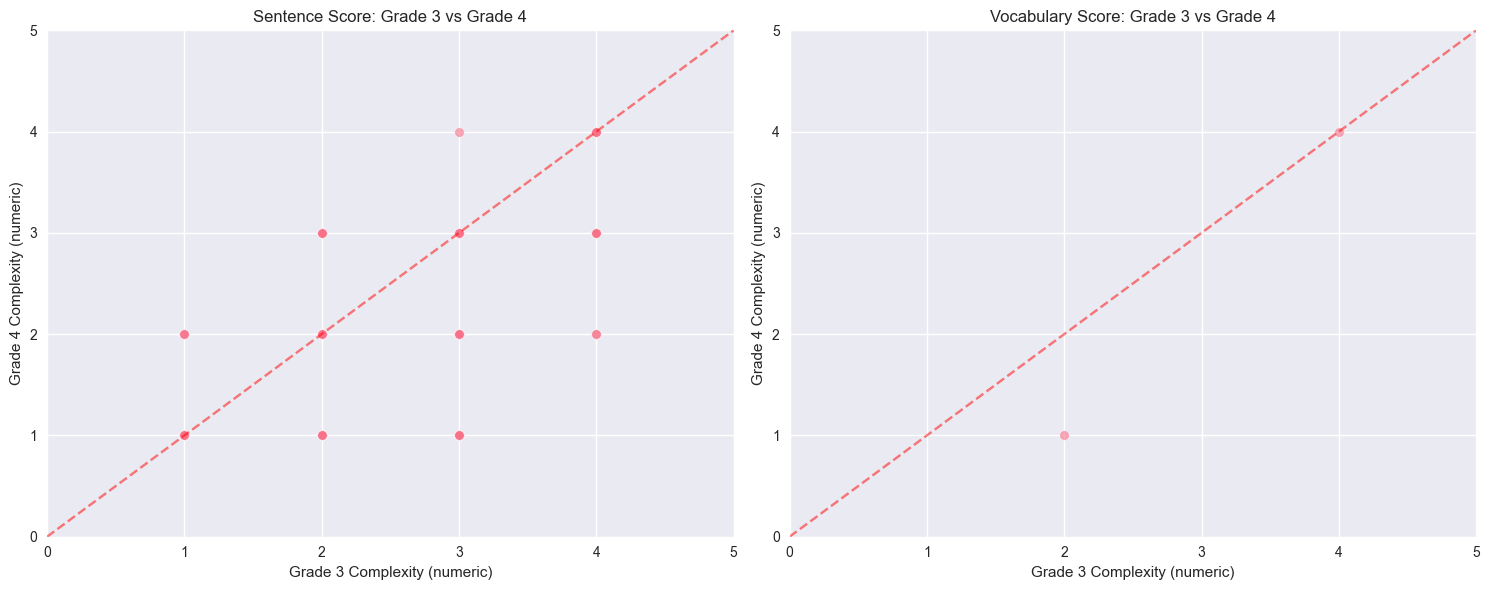

Interpretation:
The cross-grade ratings generally make logical sense - most texts are rated
as equally or more complex for Grade 4 compared to Grade 3. However, the
presence of some texts rated as more complex for Grade 3 suggests either:
1. Annotation inconsistency between different annotator teams
2. Contextual factors that might make a text more challenging for younger students
3. Random variation in the annotation process
Overall, the pattern is reasonably consistent with educational expectations.


In [ ]:
print("Cross-Grade Ratings Sanity Check")

# find texts that appear in both grades

texts_in_both_grades = df.groupby('Clear ID').filter(lambda x: len(x) > 1)

# pivoting to have both grades in one row

pivot_df = texts_in_both_grades.pivot_table(
    index='Clear ID', 
    columns='Grade', 
    values=['Sentence Score', 'Vocabulary Score'],
    aggfunc='first'
)

# flatten column names

pivot_df.columns = [f'{col[0]}_grade{col[1]}' for col in pivot_df.columns]
pivot_df = pivot_df.reset_index()

print(f"Number of texts rated for both grades: {len(pivot_df)}")

# converting complexity scores to numerical values (mapped)

def complexity_to_numeric(score):
    mapping = {
        'slightly complex': 1,
        'moderately complex': 2, 
        'very complex': 3,
        'exceedingly complex': 4,
        'not scored': -1
    }
    return mapping.get(score, -1)

# applying conversion

for col in pivot_df.columns:
    if 'Score' in col:
        pivot_df[f'{col}_numeric'] = pivot_df[col].apply(complexity_to_numeric)

# patterns

print("\nComplexity Patterns Across Grades")

# sentence score patterns

sentence_grade3 = pivot_df['Sentence Score_grade3_numeric']
sentence_grade4 = pivot_df['Sentence Score_grade4_numeric']

sentence_comparison = pd.DataFrame({
    'grade3': sentence_grade3,
    'grade4': sentence_grade4,
    'difference': sentence_grade4 - sentence_grade3
})

print("Sentence Score changes from Grade 3 to Grade 4:")
print(sentence_comparison['difference'].value_counts().sort_index())

# vocabulary score patterns  

vocab_grade3 = pivot_df['Vocabulary Score_grade3_numeric']
vocab_grade4 = pivot_df['Vocabulary Score_grade4_numeric']

vocab_comparison = pd.DataFrame({
    'grade3': vocab_grade3,
    'grade4': vocab_grade4, 
    'difference': vocab_grade4 - vocab_grade3
})

print("\nVocabulary Score changes from Grade 3 to Grade 4:")
print(vocab_comparison['difference'].value_counts().sort_index())

# unexpected patterns (same text rated as more complex for lower grade)

unexpected_sentence = sentence_comparison[sentence_comparison['difference'] < 0]
unexpected_vocab = vocab_comparison[vocab_comparison['difference'] < 0]

print(f"\nUnexpected patterns (rated more complex for Grade 3 than Grade 4):")
print(f"Sentence Score: {len(unexpected_sentence)} texts")
print(f"Vocabulary Score: {len(unexpected_vocab)} texts")

# examples of unexpected patterns

if len(unexpected_sentence) > 0:
    print("\nExamples of unexpected Sentence Score patterns:")
    sample_unexpected = unexpected_sentence.head(3).index
    for index in sample_unexpected:
        clear_id = pivot_df.loc[index, 'Clear ID']
        original_data = df[df['Clear ID'] == clear_id][['Clear ID', 'Grade', 'Sentence Score', 'Vocabulary Score']]
        print(original_data)

# visuals

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# sentence score comparison

sns.scatterplot(data=sentence_comparison, x='grade3', y='grade4', ax=ax1, alpha=0.6)
ax1.plot([0, 5], [0, 5], 'r--', alpha=0.5)  # diagonal line
ax1.set_title('Sentence Score: Grade 3 vs Grade 4')
ax1.set_xlabel('Grade 3 Complexity (numeric)')
ax1.set_ylabel('Grade 4 Complexity (numeric)')
ax1.set_xlim(0, 5)
ax1.set_ylim(0, 5)

# vocabulary score comparison

sns.scatterplot(data=vocab_comparison, x='grade3', y='grade4', ax=ax2, alpha=0.6)
ax2.plot([0, 5], [0, 5], 'r--', alpha=0.5)  # diagonal line
ax2.set_title('Vocabulary Score: Grade 3 vs Grade 4')
ax2.set_xlabel('Grade 3 Complexity (numeric)')
ax2.set_ylabel('Grade 4 Complexity (numeric)')
ax2.set_xlim(0, 5)
ax2.set_ylim(0, 5)

plt.tight_layout()
plt.show()

print("Interpretation:")
print("The cross-grade ratings generally make logical sense - most texts are rated")
print("as equally or more complex for Grade 4 compared to Grade 3. However, the")
print("presence of some texts rated as more complex for Grade 3 suggests either:")
print("1. Annotation inconsistency between different annotator teams")
print("2. Contextual factors that might make a text more challenging for younger students")
print("3. Random variation in the annotation process")
print("Overall, the pattern is reasonably consistent with educational expectations.")

# Question 7.

AI Assistant Reflection 

In the completion of this exam, I utilized AI assistants to strategically analyze several aspects of the data and manipulate the columns shown to get what I needed for a given question. For complex tasks like regular expression patterns, I needed to decode annotator counts from rationale text, and AI helped to generate structures that I could refine myself for iterative testing purposes. The multi-step data transformation required for cross-grade analysis also benefited from AI suggestions on pandas operations and data validation. To ensure the reliability of the code that the AI was generating, I always made an effort to test the code on small subsets of the data before enacting the process on the entirety of the information. Furthermore, by using pandas documentation in collaboration with the conventions of the data’s documentation, I was able to have AI make patterns that fit the scope of variables for each and every observation text. If every one of the intermediary results produced the expected outputs that I could logically predict from my given domain expertise, then the AI was doing a good enough job for practical application to the question. For instance, the handling of “not scored” and pivot tables by the AI was clean and thorough enough for me to adjust the use cases to my specific coding needs. If the prompt that was given to AI assistants was not specific enough, then the vague responses that would initially be produced for generic solutions wouldn’t be of any real help. The detailed prompts that I gave included data structures and desired outputs so that much more useful code could be generated. By engaging in iterative dialogue and combining multiple AI suggestions with my own understanding, I developed more robust solutions than any single response provided. 

# Question 8. 

The Flesch-Kincaid Mystery 

In [ ]:
print("Flesch-Kincaid Mystery")

# mean Flesch-Kincaid score

if 'Flesch Kincaid' in df.columns:
    fk_scores = pd.to_numeric(df['Flesch Kincaid'], errors='coerce')
    mean_fk = fk_scores.mean()
    print(f"Mean Flesch-Kincaid score: {mean_fk:.2f}")
    
    # comparison with grade level expectations
    
    print("\nAnalysis (In-Depth):")
    print("The Flesch-Kincaid score of ~7.2 suggests these texts are appropriate for 7th graders,")
    print("but they're labeled for 3rd/4th grade.")
        
    # test hypothesis with data
    
    if 'Sentence Score' in df.columns and 'Vocabulary Score' in df.columns:
        
        # check complex vocabulary correlates with high FK scores
        
        complex_vocab = df[df['Vocabulary Score'].isin(['very complex', 'exceedingly complex'])]
        simple_vocab = df[df['Vocabulary Score'].isin(['slightly complex', 'moderately complex'])]
        
        print(f"\nComplex vocabulary texts FK mean: {pd.to_numeric(complex_vocab['Flesch Kincaid'], errors='coerce').mean():.2f}")
        print(f"Simple vocabulary texts FK mean: {pd.to_numeric(simple_vocab['Flesch Kincaid'], errors='coerce').mean():.2f}")
        
else:
    print("Flesch Kincaid column not found in dataset")


Flesch-Kincaid Mystery
Mean Flesch-Kincaid score: 7.24

Analysis (In-Depth):
The Flesch-Kincaid score of ~7.2 suggests these texts are appropriate for 7th graders,
but they're labeled for 3rd/4th grade.

Complex vocabulary texts FK mean: 7.95
Simple vocabulary texts FK mean: 6.41
